1) Load in the dataset `https://d1pqsl2386xqi9.cloudfront.net/notebooks/Default.csv` into a pandas dataframe

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.linear_model import LogisticRegression
from sklearn.linear_model import Ridge
from sklearn.model_selection import train_test_split
from sklearn.metrics import roc_curve, auc
from sklearn.preprocessing import StandardScaler
from sklearn.tree import DecisionTreeClassifier, export_graphviz
from IPython.display import Image
import pydotplus 
import pydot
import graphviz
%matplotlib inline

In [2]:
# Ploting ROC function
def plot_roc(clf, X_test, y_test, string=''):
    probas_ = clf.predict_proba(X_test)
    fpr, tpr, thresholds = roc_curve(y_test, probas_[:, 1])
    roc_auc = auc(fpr, tpr)
    plt.clf()
    plt.plot(fpr, tpr, '.-',label='ROC curve (area = %0.2f)' % roc_auc)
    plt.plot([0, 1], [0, 1], 'k--')
    plt.xlim([0.0, 1.0])
    plt.ylim([0.0, 1.0])
    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive Rate')
    plt.title('Receiver operating characteristic '+string)
    plt.legend(loc="lower right")
    plt.show()

In [3]:
df = pd.read_csv('https://d1pqsl2386xqi9.cloudfront.net/notebooks/Default.csv', index_col=0)

In [4]:
df.head()

,default,student,balance,income
1,No,No,729.526495,44361.625074
2,No,Yes,817.180407,12106.134700
3,No,No,1073.549164,31767.138947
4,No,No,529.250605,35704.493935
5,No,No,785.655883,38463.495879


In [5]:
df['default'] = df['default'].replace('No', 'default_No').replace('Yes', 'default_Yes')
df['student'] = df['student'].replace('No', 'student_No').replace('Yes', 'student_Yes')

2) Convert `default` and `student` to categorical variables.

In [6]:
df_default = pd.get_dummies(df['default'])
df_student = pd.get_dummies(df['student'])
df_final = pd.concat([df.drop(['default', 'student'], axis=1), df_default, 
                   df_student], axis=1)
df_final = df_final.drop(['default_No', 'student_No'], axis=1)

3) Make boxplots of all of the variables and a scatter plot of of (balance,income) with the color
of the outcome of `default` labeled red if yes and blue if no. 

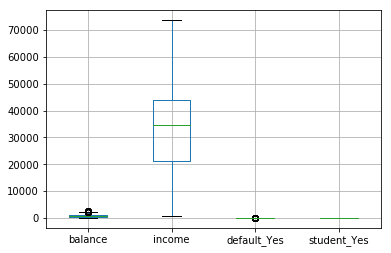

In [7]:
df_final.boxplot()

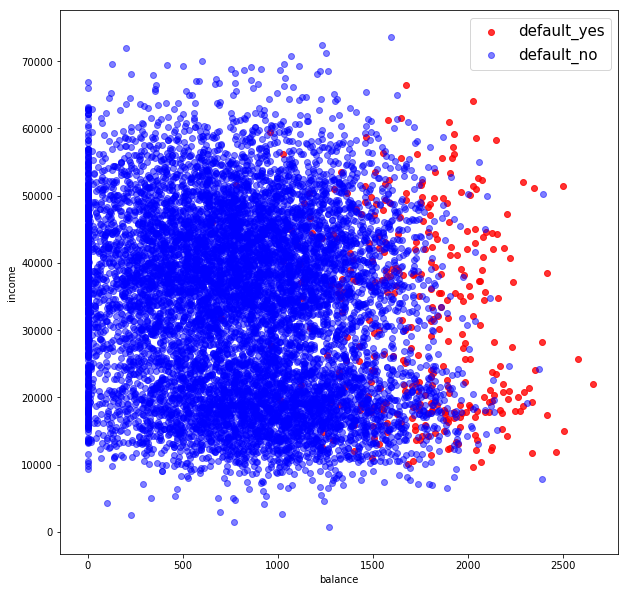

In [8]:
df_y = df_final[df_final.default_Yes==1]
df_n = df_final[df_final.default_Yes==0]
plt.figure(figsize=(10, 10))
plt.scatter(x=df_y['balance'], y=df_y['income'], c='r', label='default_yes', alpha=0.8)
plt.scatter(x=df_n['balance'], y=df_n['income'], c='b', label='default_no', alpha=0.5)
plt.xlabel('balance')
plt.ylabel('income')
plt.legend(prop={'size':15})

4) Train a model to predict if a student defaults on their loan or not using LogisticRegression based soley
on the `balance` and `income` variables. Plot the decision boundary in the scatter plot you made in 3) and compute the AUC ROC.

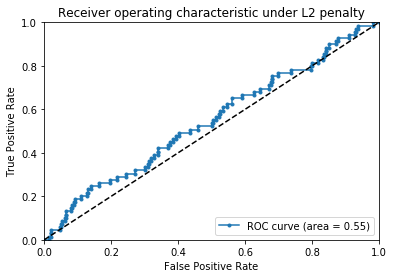

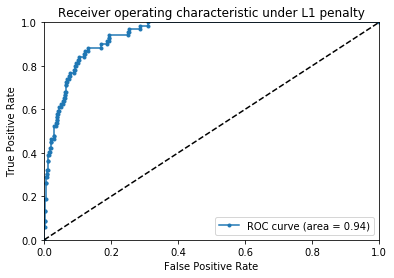

In [9]:
X = df_final[['balance', 'income']]
y = df_final.default_Yes
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)
clf = LogisticRegression(penalty='l2', C=100)
clf.fit(X_train, y_train)
plot_roc(clf, X_test, y_test, 'under L2 penalty')


X = df_final[['balance', 'income']]
y = df_final.default_Yes
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)
clf = LogisticRegression(penalty='l1', C=100)
clf.fit(X_train, y_train)
plot_roc(clf, X_test, y_test, 'under L1 penalty')

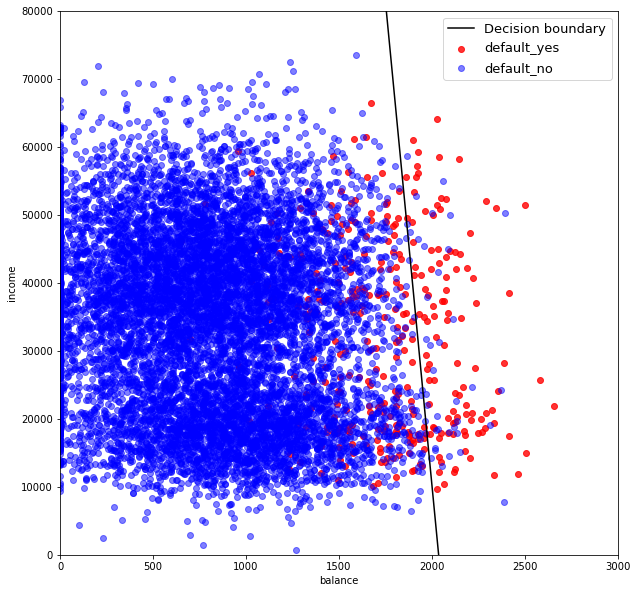

In [10]:
w0 = clf.intercept_
w1, w2 = clf.coef_[0]
dt = np.linspace(0, 3000, 3000)

f, ax = plt.subplots(figsize=(10, 10))
ax.scatter(x=df_y['balance'], y=df_y['income'], c='r', label='default_yes', alpha=0.8)
ax.scatter(x=df_n['balance'], y=df_n['income'], c='b', label='default_no', alpha=0.5)
ax.plot(dt, (-w0-w1*dt)/w2, 'k', label='Decision boundary')
ax.set(xlim=(0, 3000), ylim=(0, 80000),
       xlabel="balance", ylabel="income")
ax.legend(prop={'size':13})

5) Repeat 4) but with the student variable included. Optimize using Ridge regression and plot the ranking
of coefficients.  How does performance improve with the added variable?

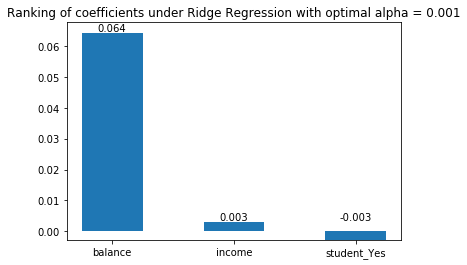

In [11]:
X = df_final[['balance', 'income', 'student_Yes']]
y = df_final.default_Yes
scaler = StandardScaler()
X = X.as_matrix().astype(np.float)
X = scaler.fit_transform(X)
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

alphas = np.logspace(-8, -3, 100)
score = []
for alpha in alphas:
    clf = Ridge(alpha=alpha)
    clf.fit(X_train, y_train)
    score.append(clf.score(X_test, y_test))
opt_index = np.array(score).argmax()

clf = Ridge(alpha=alphas[opt_index])
clf.fit(X_train, y_train)
ind = np.arange(3)  
width = 0.50

fig = plt.figure()
ax = fig.add_subplot(1, 1, 1)
ax.bar(ind, clf.coef_, width)
ax.set_xticks(ind)
ax.set_xticklabels(('balance', 'income', 'student_Yes'))
rects = ax.patches

for rect, label in zip(rects, clf.coef_):
    height = rect.get_height()
    ax.text(rect.get_x() + rect.get_width()/2, 1.*height, np.round(label, 3), ha='center', va='bottom')
ax.set_title('Ranking of coefficients under Ridge Regression with optimal alpha = %.3f' %(alphas[opt_index]))

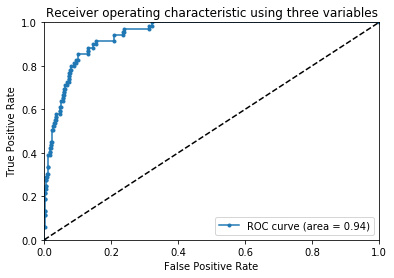

In [12]:
X = df_final[['balance', 'income', 'student_Yes']]
y = df_final.default_Yes
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)
clf = LogisticRegression(penalty='l1', C=100)
clf.fit(X_train, y_train)
plot_roc(clf, X_test, y_test, 'using three variables')

**(5) Comment**

When I add the 'student_Yes' variable, Roc remains 0.94. Thus, adding 'student_Yes' has less influence on the performance.

6) Using cross validation, check that the model you built in 5) is robust (generalizes to other random folds of the dataset).

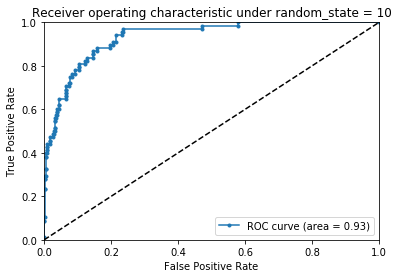

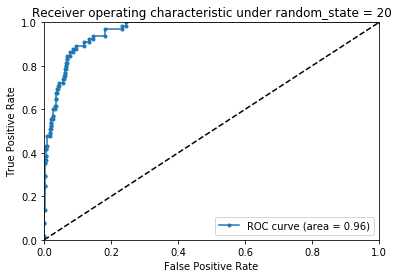

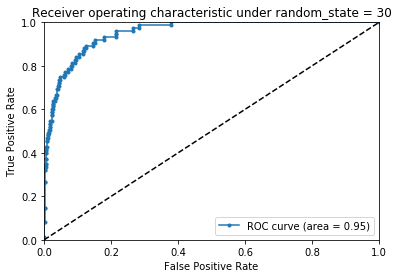

In [13]:
X = df_final[['balance', 'income']]
y = df_final.default_Yes
seed = [10, 20, 30]
for s in seed:
    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=s)
    clf = LogisticRegression(penalty='l1', C=100)
    clf.fit(X_train, y_train)
    plot_roc(clf, X_test, y_test, 'under random_state = %s' %s)

**I have tried random_state = 10, 20, 30 and get a similar result. So it is robust.**

7) Train a Decision Tree classifier with maximum depth 5 and plot the decision tree. How does performance compare?

In [14]:
X = df_final[['balance', 'income']]
y = df_final.default_Yes
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)
tree = DecisionTreeClassifier(criterion='entropy',  max_depth=5)
tree.fit(X_train, y_train)
export_graphviz(tree, out_file='tree.dot')                



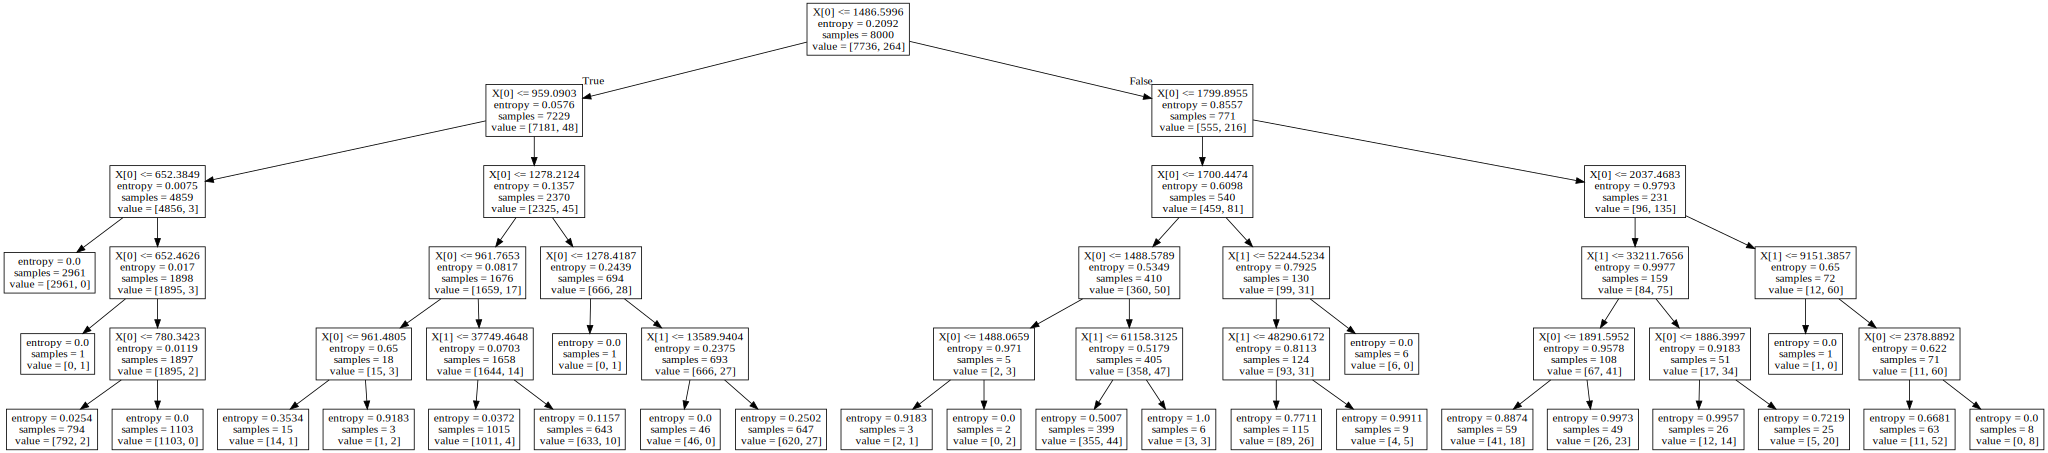

In [15]:
with open("tree.dot") as f:
    dot_graph = f.read()
graphviz.Source(dot_graph, format='png')

8) Find the optimal decision tree depth and compute the AUC ROC. 

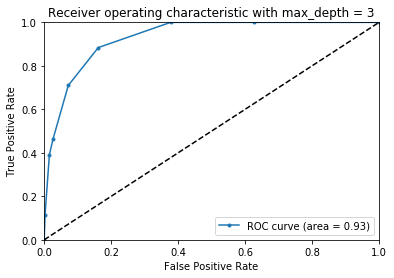

In [16]:
roc_auc = []
max_depth = xrange(1, 11)
for i in max_depth:
    tree = DecisionTreeClassifier(criterion='entropy',  max_depth=i)
    tree.fit(X_train, y_train)
    probas_ = tree.predict_proba(X_test)

    fpr, tpr, thresholds = roc_curve(y_test, probas_[:, 1])
    roc_auc.append(auc(fpr, tpr))
opt_index = np.array(roc_auc).argmax()

# Optimal max_depth of decision tree
tree = DecisionTreeClassifier(criterion='entropy',  max_depth=max_depth[opt_index])
tree.fit(X_train, y_train)
plot_roc(tree, X_test, y_test, 'with max_depth = %s' %(max_depth[opt_index]))
